In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import meshy

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import pydicom
import functools
import mcubes


In [2]:
#image = meshy.read_dicom('../series-00000/', unscaled = True)
image = meshy.read_dicom('../series-00000/', unscaled = True, crop = 450, axis = 0)



100%|██████████| 361/361 [00:10<00:00, 34.21it/s]


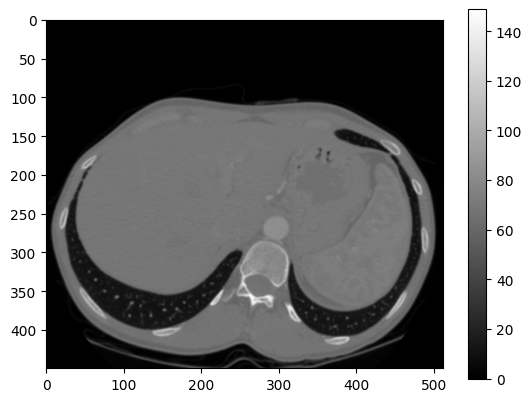

In [3]:
plt.imshow(image[:, :, 0])

plt.colorbar()
plt.gray()

In [4]:
fg_mask = meshy.make_fg_mask(image, use_kmeans = False, fg_threshold = 60)



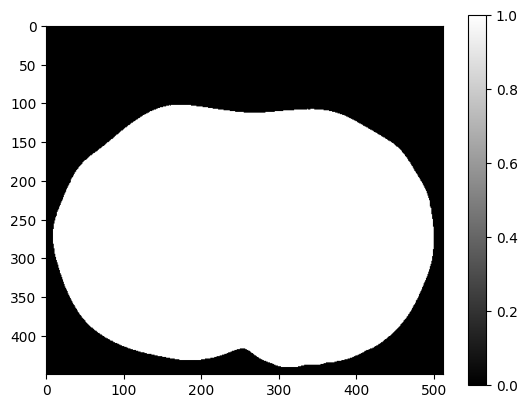

In [5]:
plt.imshow(fg_mask[:, :, 0])
plt.colorbar()
plt.gray()

In [6]:
vertices, triangles = meshy.make_surface_mesh(fg_mask, './body_surface_smoothed.obj')